# Mount drive and import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/pinns-main/src/cooling')

In [19]:
## Import required packages and check if CPU or GPU can be utilized.
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

## pre-defined functions and classes
from network import Net, NetDiscovery
from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
## torch.cuda.get_device_name(0) # check device name

sns.set_theme()
torch.manual_seed(42)
print(DEVICE)

cuda


In [9]:
torch.cuda.get_device_name(0)

'Tesla T4'

#  1 - Physics Only

Temperature Prediction of a cooling coffee cup.

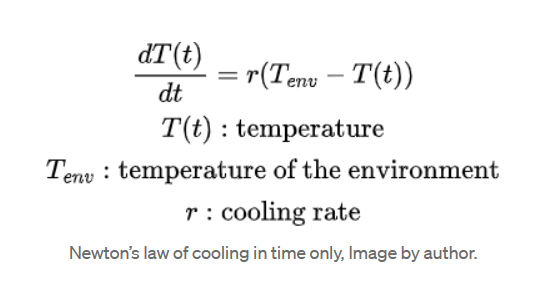

Text(0.5, 0, 'Time (s)')

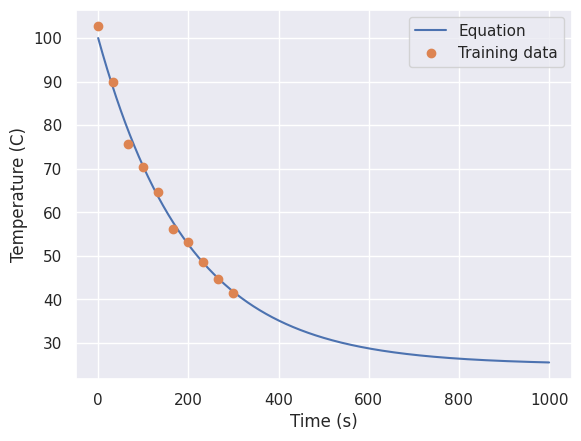

In [14]:
## Physics Only (approximate the temperature of the coffee cup using Newton's law of cooling)
## Create training data from physics equation
np.random.seed(10)

Tenv = 25 #Environmental Temperature
T0 = 100 # Start Temperature
R = 0.005 #Cooling Rate
times = np.linspace(0, 1000, 1000) # timepoints
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R) # PDE (cooling law)
temps = eq(times) # temperature based on cooling law

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10) ## training data

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


# 2 - Vanilla Networks (Data Only - ~1m30)

Train a Neural Network (Data Only)

Epoch 0/20000, loss: 4775.81
Epoch 2000/20000, loss: 2513.81
Epoch 4000/20000, loss: 2157.31
Epoch 6000/20000, loss: 683.87
Epoch 8000/20000, loss: 29.87
Epoch 10000/20000, loss: 1.25
Epoch 12000/20000, loss: 0.73
Epoch 14000/20000, loss: 0.64
Epoch 16000/20000, loss: 0.54
Epoch 18000/20000, loss: 0.41


Text(0, 0.5, 'Loss')

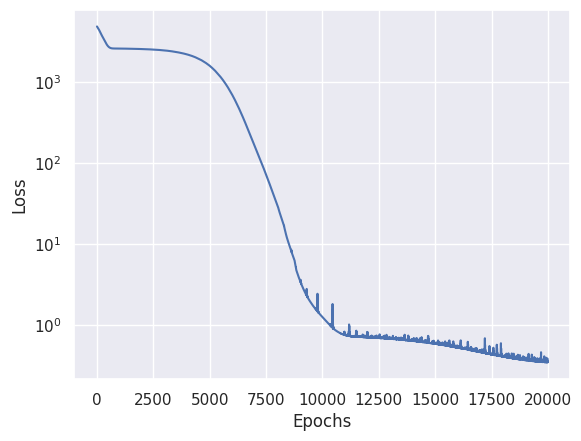

In [15]:
## Train a Neural Network (Data Only)
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

## Net class pre-defined in network.py

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Calculate/define the l2 regularization term for a given neural network model.

In [12]:
## Calculate/define the l2 regularization term for a given neural network model.
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))
    ## Sum of Squared Parameters to penalize large weights and prevent overfitting

 Vanilla NN including L2 regularization to prevent overfitting

Epoch 0/20000, loss: 11277.29
Epoch 2000/20000, loss: 3660.53
Epoch 4000/20000, loss: 2122.29
Epoch 6000/20000, loss: 1246.13
Epoch 8000/20000, loss: 811.13
Epoch 10000/20000, loss: 625.21
Epoch 12000/20000, loss: 551.12
Epoch 14000/20000, loss: 497.52
Epoch 16000/20000, loss: 452.54
Epoch 18000/20000, loss: 405.99


Text(0, 0.5, 'Loss')

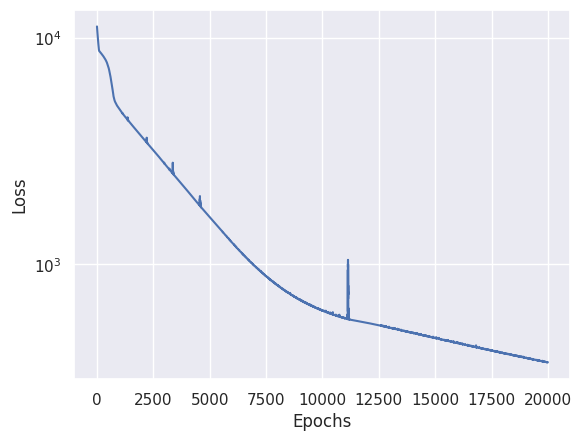

In [16]:
## Vanilla NN including L2 regularization to prevent overfitting
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Predict using models, visualize and compare

Text(0.5, 0, 'Time (s)')

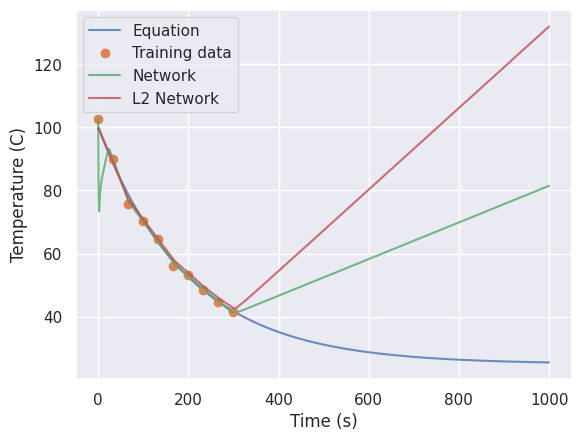

In [17]:
##Predict using models, visualize and compare
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


# 3 - PINN (Data + Physics) (~10min)

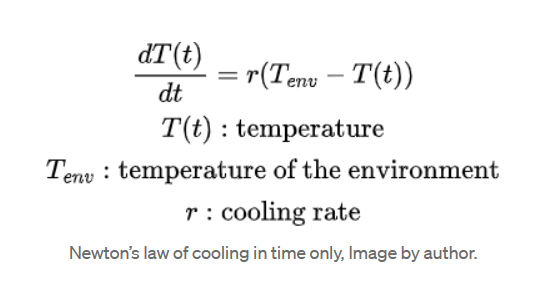

Define the physics loss function

In [19]:
##Define the physics loss function
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0] ## computes the gradient of temps
    pde = R*(Tenv - temps) - dT ## partial differential equation based on physical law

    return torch.mean(pde**2) ## avg squared residuals

Train model using physics loss model

Epoch 0/30000, loss: 4776.84
Epoch 3000/30000, loss: 2433.64
Epoch 6000/30000, loss: 512.49
Epoch 9000/30000, loss: 1.66
Epoch 12000/30000, loss: 1.37
Epoch 15000/30000, loss: 1.36
Epoch 18000/30000, loss: 1.34
Epoch 21000/30000, loss: 1.34
Epoch 24000/30000, loss: 1.33
Epoch 27000/30000, loss: 1.33


Text(0, 0.5, 'Loss')

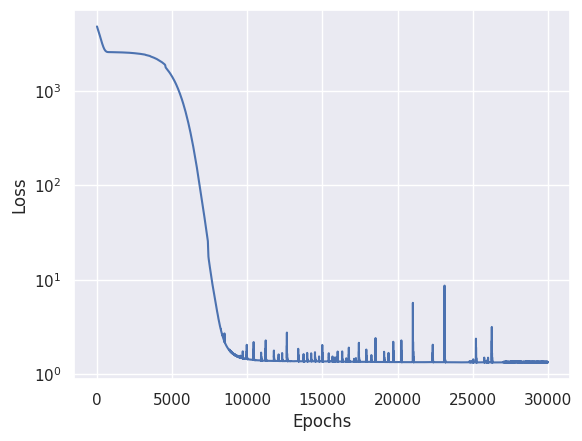

In [20]:
## Train model using physics loss model
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Predict and visualize PINN compated to Physics Equations

Text(0.5, 0, 'Time (s)')

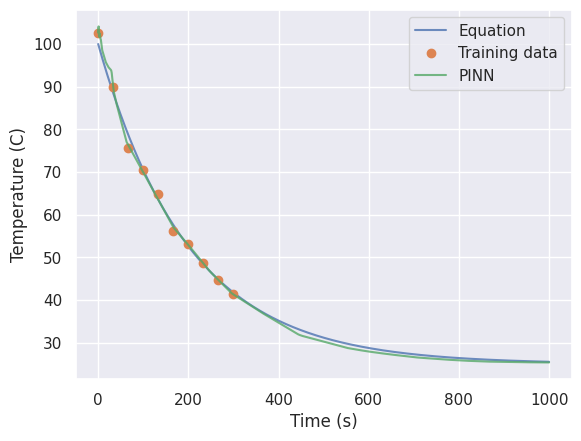

In [21]:
##Predict and visualize PINN compated to Physics Equations
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 4 Parameter discovery (~13min)

In [22]:
## Adding flexibiliy: PINNs for equation discovery
## Introduce differentiable variable 'r' instead of the constant R (cooling rate)
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT ## r is unknown, differentiable variable

    ## old physics loss function:  pde = R*(Tenv - temps) - dT

    return torch.mean(pde**2)

Epoch 0/40000, loss: 4817.01
Epoch 4000/40000, loss: 2500.85
Epoch 8000/40000, loss: 2040.82
Epoch 12000/40000, loss: 476.34
Epoch 16000/40000, loss: 4.59
Epoch 20000/40000, loss: 2.64
Epoch 24000/40000, loss: 2.18
Epoch 28000/40000, loss: 1.55
Epoch 32000/40000, loss: 1.31
Epoch 36000/40000, loss: 1.18


Text(0, 0.5, 'Loss')

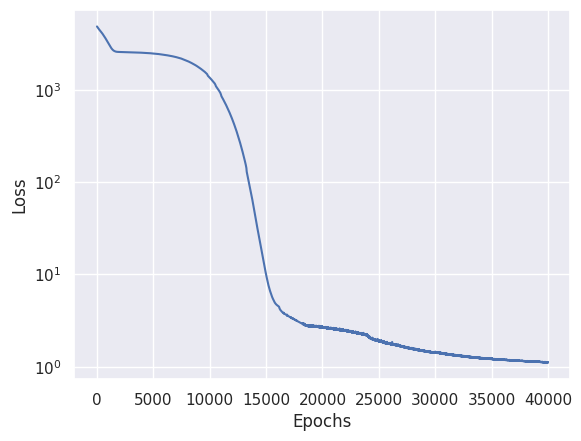

In [23]:
## Train NN using PINN + differentiable variable 'r'
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Parameter containing:
tensor([0.0051], requires_grad=True)


Text(0.5, 0, 'Time (s)')

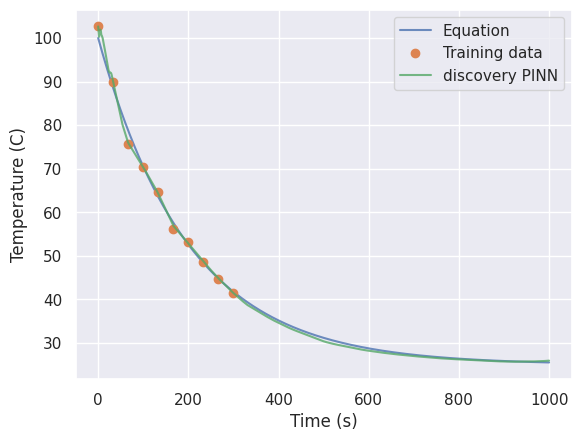

In [24]:
preds = netdisc.predict(times)
print(netdisc.r)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')